In [3]:
!pip install --upgrade hifi-gan-bwe

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 57.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 67.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 65.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 42.2 MB/s eta 0:00:0000:0100:01


In [5]:
import audioread
import numpy as np
import torch
from IPython.display import Audio
from hifi_gan_bwe import BandwidthExtender
import os
import time

In [6]:
model = BandwidthExtender.from_pretrained("hifi-gan-bwe-10-42890e3-vctk-48kHz")

downloading hifi-gan-bwe-10-42890e3-vctk-48kHz.pt: 4200KB [00:00, 24547.37KB/s]


In [7]:
originalFilePath = "FullBandFiles/p232_001.wav"

In [8]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from scipy.signal import decimate

fs, original_data = wav.read(originalFilePath)
#dele på 32767 her
scaled_original_data = original_data.astype(np.float32)/ 32767.0

def plot_signal(data, fs):
    n = len(data)
    x_axis = np.linspace(0, n/fs, n)
    plt.plot(x_axis, original_data)
    plt.show()

def plot_fft(data, fs):
    samples = data.shape[0]
    period = 1/fs

    fft = np.fft.fft(data)
    freq = np.fft.fftfreq(samples, period)

    plt.plot(freq, fft)
    plt.show()



In [24]:
new_fs = 16000
q = int(fs/new_fs)

def downsample_data(data):
    downsampled_data = decimate(data, q, ftype='fir', zero_phase=True) #Zero_phase=True hindrer faseforstyrrelse
    wav.write('downsampled_audio.wav', new_fs, downsampled_data.astype(np.int16))
    path = 'downsampled_audio.wav'

    return downsampled_data, path

def downsample_data2(data):
    downsampled_data = decimate(data, q, ftype='fir', zero_phase=True)
    new_downsampled_data = downsampled_data.reshape([-1, 1]).astype(np.float32)/32767

    return new_downsampled_data

downsampled_data, filepath = downsample_data(original_data)

In [13]:
def preprocess_data(filepath):
    with audioread.audio_open(filepath) as input_:
        sample_rate = input_.samplerate #16 000
        x = (
            np.hstack([np.frombuffer(b, dtype=np.int16) for b in input_])
            .reshape([-1, input_.channels]) #[-1,1]
            .astype(np.float32)
            / 32767.0
        )
        print(input_.channels)
    return x

preprocessed_data = preprocess_data(filepath) 

new_downsampled_data = downsampled_data.reshape([-1, 1]).astype(np.float32)


print('Original downsampled data: ', downsampled_data[:5]/32767)
print('New downsampled data: ', new_downsampled_data[:5]/32767)
print('After saving and preprocessing: ', preprocessed_data[:5])
print(downsampled_data.dtype)

1
Original downsampled data:  [0.00189471 0.00287201 0.00250195 0.00269546 0.00258915]
New downsampled data:  [[0.00189471]
 [0.00287201]
 [0.00250195]
 [0.00269546]
 [0.00258915]]
After saving and preprocessing:  [[0.00189215]
 [0.00286874]
 [0.002472  ]
 [0.00268563]
 [0.00256355]]
float64


In [19]:
def run_model(preprocessed_data):
    with torch.no_grad():
        y = np.stack([model(torch.from_numpy(preprocessed_data), new_fs) for preprocessed_data in preprocessed_data.T]).T
    return y


y = run_model(new_downsampled_data)

In [25]:
folderpath = 'FullBandFiles'
folderlist = os.listdir(folderpath)[:2]
print(folderlist)
fs, original_data = wav.read(originalFilePath)
fft_length =  int(len(original_data)/2)
sum_diff_fft = np.zeros(int(fft_length/2)+1)
abs_sum_diff_fft = np.zeros(int(fft_length/2)+1)
sum_original_fft = np.zeros(int(fft_length/2)+1)
sum_bwe_fft = np.zeros(int(fft_length/2)+1)

['p257_085.wav', 'p232_365.wav']


In [26]:
start_time = time.time()


for index, filename in enumerate(folderlist):
    
    temp_start = time.time()
    
    #Fetch original data
    filepath = os.path.join(folderpath, filename)
    if filename[-4:].lower() != '.wav':
        continue
    fs, original_data = wav.read(filepath)
    

    #Downsample data and save as file
    #downsampled_data, filepath = downsample_data(original_data)
    downsampled_data = downsample_data2(original_data)
    

    #Run model and scale data
    
    #prepped_data = preprocess_data(filepath)
    bwe_data = run_model(downsampled_data)
    bwe_data = bwe_data.reshape(-1)
    scaling_factor = bwe_data.max()/original_data.max()
    scaled_original_data = original_data*scaling_factor

    #print(original_data[:10])
    #print(bwe_data[:10])

    #Create FFTs
    original_fft = np.abs(np.fft.rfft(scaled_original_data, n = fft_length))
    bwe_fft = np.abs(np.fft.rfft(bwe_data, n = fft_length))
    
    #print(original_fft.shape)
    #print(bwe_fft.shape)

    
    #Find difference
    diff_fft = original_fft - bwe_fft
    normalized_diff_fft = diff_fft/original_fft.max()*100
    abs_normalized_diff_fft = abs(diff_fft)/original_fft.max()*100
    
    sum_diff_fft +=normalized_diff_fft
    abs_sum_diff_fft +=abs_normalized_diff_fft
    sum_original_fft += original_fft
    sum_bwe_fft += bwe_fft
    
    
    temp_stop = time.time()
    temp_elapsed = int(temp_stop - start_time)
    if index%50==0:
        print(f'Iteration {index + 1} out of {len(folderlist)}. Elapsed time: ' +
      (f'{temp_elapsed // 60} minutes and ' if temp_elapsed >= 60 else '') +
      f'{temp_elapsed % 60} seconds')



    #print(filename, normalized_diff_fft[0])
    #print(sum_diff_fft[0])

stop_time = time.time()
elapsed_time = int(stop_time - start_time)

print(f'Total running time for {len(folderlist)} iterations: ' + (f'{elapsed_time // 60} minutes and ' if elapsed_time >= 60 else '') +
      f'{temp_elapsed % 60} seconds')


Iteration 1 out of 2. Elapsed time: 5 seconds
Total running time for 2 iterations: 9 seconds


In [27]:
def save_arrays():
    np.savez('fft_arrays.npz', array1=sum_diff_fft, array2=abs_sum_diff_fft, array3=sum_original_fft, array4=sum_bwe_fft)

save_arrays()

with np.load('fft_arrays.npz') as data:
    sum_diff_fft = data['array1']
    abs_sum_diff_fft = data['array2']
    sum_original_fft = data['array3']
    sum_bwe_fft = data['array4']



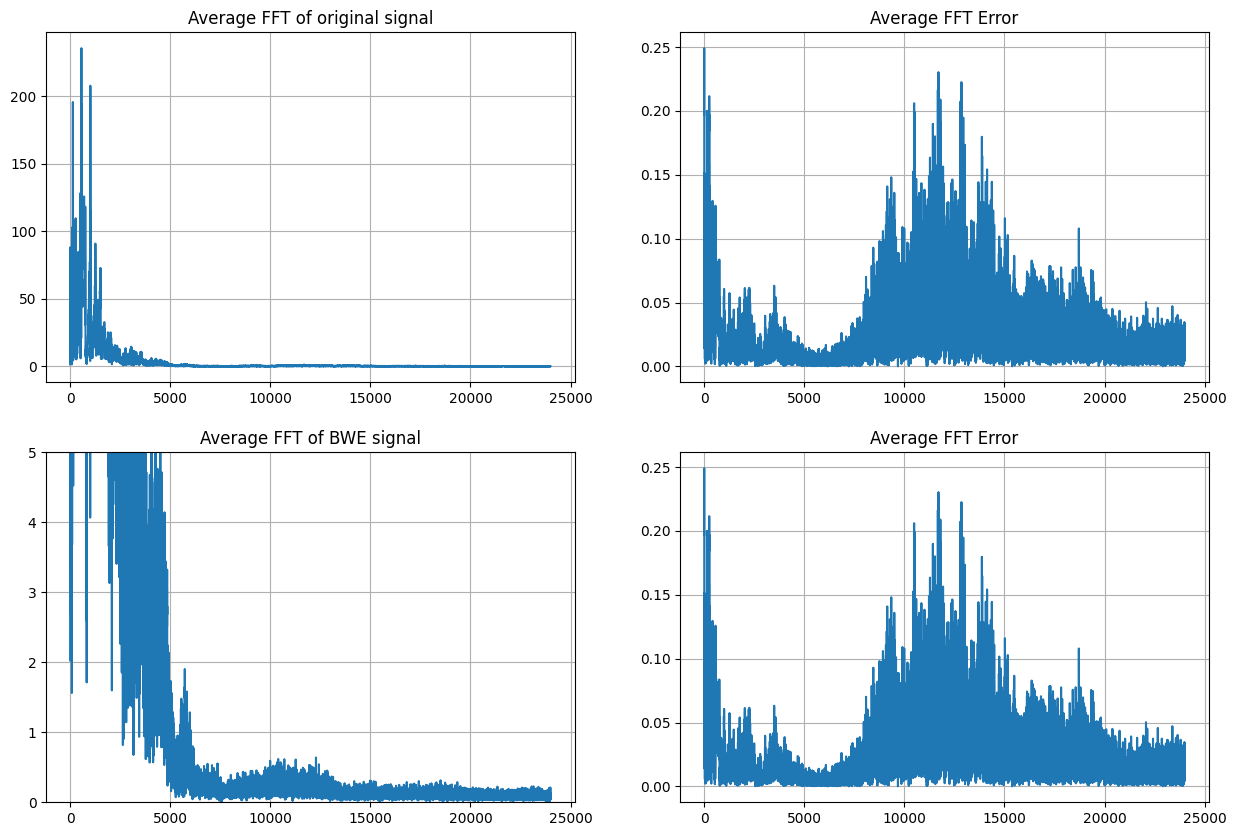

In [28]:
#Averaging FFTs
avg_diff_fft = sum_diff_fft/len(folderlist)
avg_abs_diff_fft = abs_sum_diff_fft/len(folderlist)
avg_original_fft = sum_original_fft/len(folderlist)
avg_bwe_fft = sum_bwe_fft/len(folderlist)


period = 1/fs      
freq = np.fft.rfftfreq(fft_length, period)

def plot_ffts():
        
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    ax1.plot(freq, avg_original_fft)
    ax1.set_title('Average FFT of original signal')
    ax1.grid(True)
    #ax1.set_ylim(0,5)
    #ax1.set_xlim(5000,8500)
    
    ax2.plot(freq, avg_abs_diff_fft)
    ax2.set_title('Average FFT Error')
    ax2.grid(True)
    #ax2.set_ylim(0,2)
    #ax2.set_xlim(0, 200)
    
    ax3.plot(freq, avg_bwe_fft)
    ax3.set_title('Average FFT of BWE signal')
    ax3.grid(True)
    ax3.set_ylim(0,5)
    #ax3.set_xlim(5000,8500)
    
    ax4.plot(freq, avg_abs_diff_fft)
    ax4.set_title('Average FFT Error')
    ax4.grid(True)
    #ax4.set_ylim(0,2)
    #ax4.set_xlim(7000,24000)
    

    #fig.savefig('Results/original_BWE+error.png', dpi=100)

def plot_and_save():
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(freq, avg_original_fft)
    #ax1.set_title("Average FFT of BWE signal")
    
    ax2.plot(freq, avg_original_fft)
    ax2.set_ylim(0,10)
    
    #fig2.suptitle("Average FFT of original signal", fontsize=20)
    fig2.savefig('Results/original_BWE+error.png', dpi=100)

#plot_and_save()

plot_ffts()

plt.show()

In [ ]:
fs, original_data = wav.read(originalFilePath)

original_fft = np.fft.fft(original_data)
scale_factor = y.max()/original_data.max()
original_fft = original_fft*scale_factor
bwe_data = y[:-1]
bwe_fft = np.fft.fft(bwe_data)
bwe_fft = bwe_fft

diff_fft = original_fft - bwe_fft
normalized_diff_fft = diff_fft*bwe_data.max()/diff_fft.max()



samples_original = original_data.shape[0]
period_original = 1/fs

samples_bwe = y.shape[0]
period_bwe = 1/new_fs


freq_original = np.fft.fftfreq(samples_original, period_original)
freq_bwe = np.fft.fftfreq(samples_bwe, period_bwe)

print(originalFilePath)  
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(freq_original, original_fft)
ax1.set_title('Original')
#ax1.set_ylim(-60,60)
ax2.plot(freq_bwe[:-1], bwe_fft)
ax2.set_title('BWE')
#ax2.set_ylim(-60,60)
ax3.plot(freq_bwe[:-1], normalized_diff_fft)
ax3.set_title('Normalized average difference')
#ax3.set_ylim(-60,60)


plt.show()

In [ ]:
folderpath = 'FullBandFiles'
folderlist = os.listdir(folderpath)

for count, filename in enumerate(folderlist):
    filepath = os.path.join(folderpath, filename)
    
    #print(count, filepath)


In [ ]:
import time

# Start timing
start_time = time.time()

# Your code here
time.sleep(2)  # Simulate some operations with a 2-second delay

# End timing
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")


In [ ]:
arr = np.random.rand(8)
arr2 = np.random.rand(8)

arr3 = arr - arr2

print(arr-arr2)
print(abs(arr-arr2))
print(arr3)

